# Build a GitHub Issue Resolver Agent

In this recipe, we'll create a **GitHub Issue Resolver Agent with Anthropic Claude 3.7 Sonnet**. Given an issue URL, the agent will:  

- Fetch and parse the issue description and comments  
- Identify the relevant repository, directories, and files  
- Retrieve and process file content  
- Determine the next steps for resolution and post them as a comment  

For this, we'll use the new experimental [Agent](https://github.com/deepset-ai/haystack-experimental/blob/main/haystack_experimental/components/agents/agent.py) component. **`Agent`** is a Haystack component that implements a tool-calling functionality with provider-agnostic chat model support. We can use `Agent` either as a standalone component or within a pipeline.

Here's what our **Github Issue Resolver Pipeline** looks like:

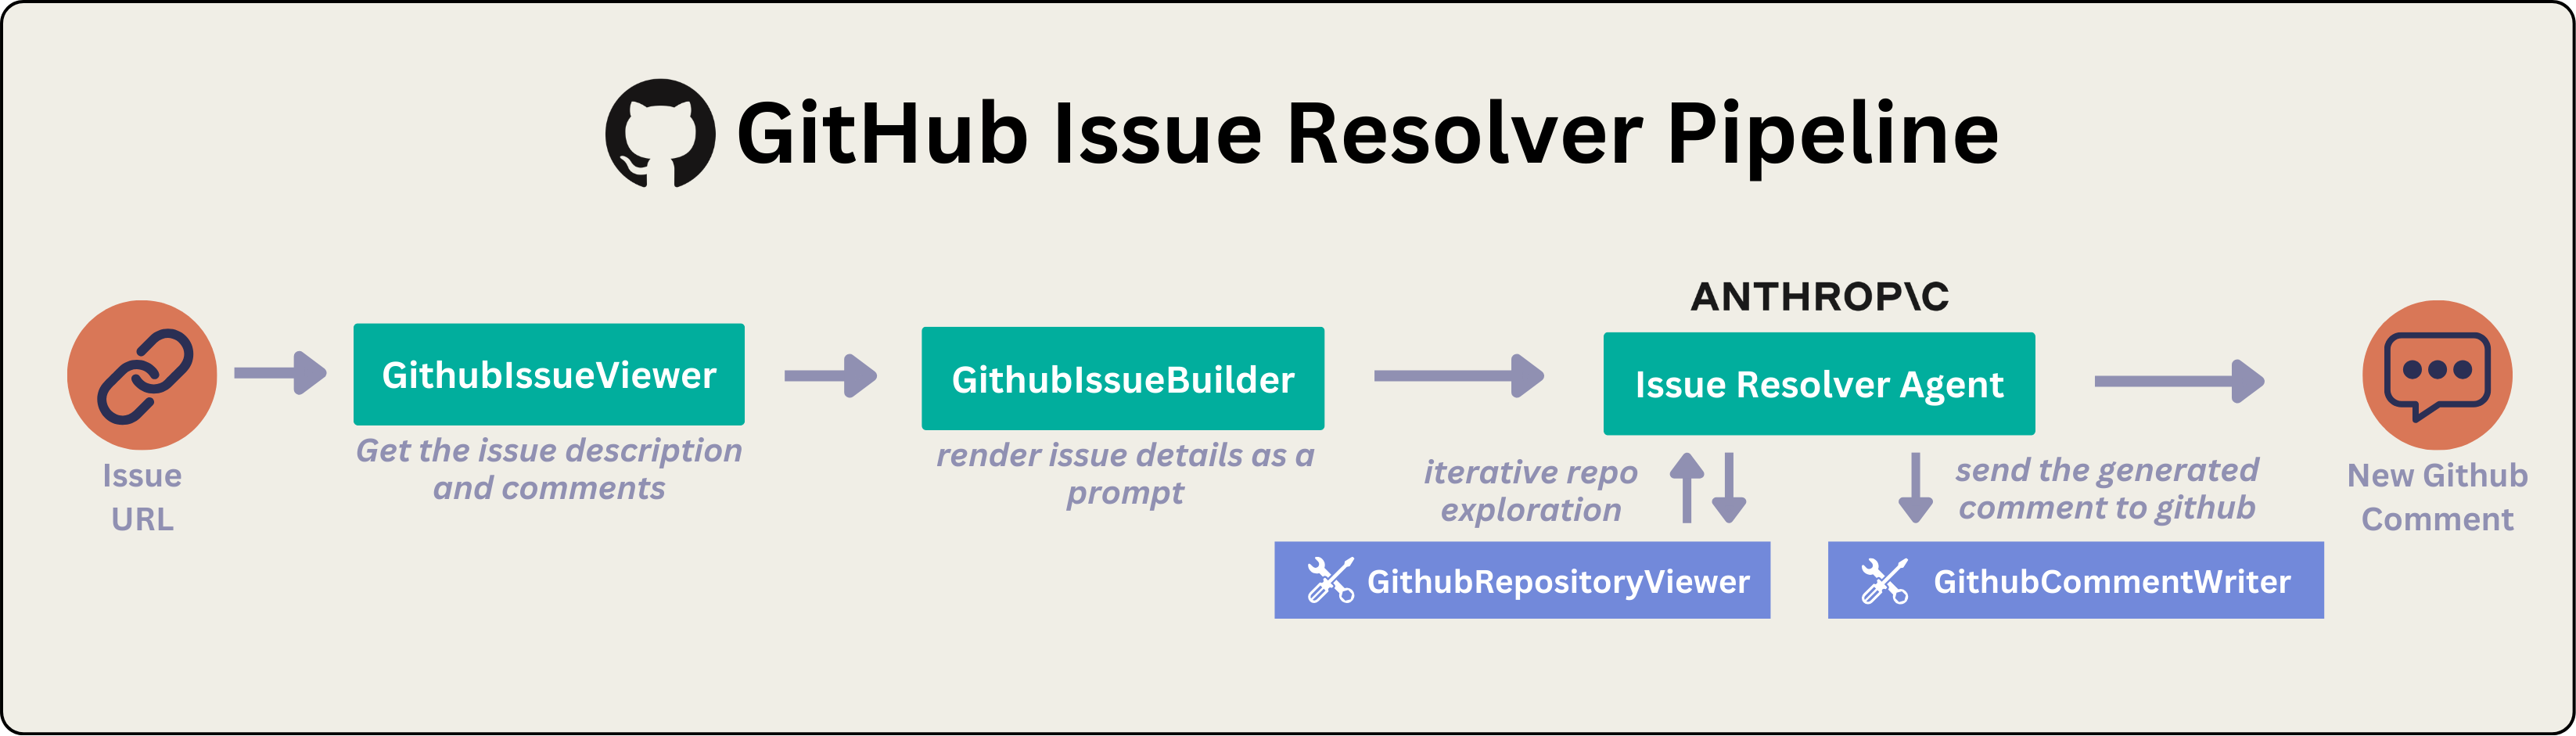

## Install dependencies

In [1]:
!pip install anthropic-haystack -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 5.7 MB/s eta 0:00:00


In [2]:
import os
from getpass import getpass
from typing import List

# Standard Haystack imports
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage, Document
from haystack_integrations.components.generators.anthropic.chat.chat_generator import AnthropicChatGenerator

# Experimental imports needed for our Agent
from haystack_experimental.components.agents import Agent
from haystack_experimental.tools.component_tool import ComponentTool
from haystack_experimental.tools.from_function import tool

## Create a custom `GithubIssueViewer` component
The custom `GithubIssueViewer` component takes a GitHub issue URL and returns a list of Haystack documents. The first document contains the main issue content, while the subsequent documents contain the issue comments.

In [3]:
import re
from typing import Any, Dict, List, Optional

import requests
from haystack import Document, component, default_from_dict, default_to_dict, logging
from haystack.utils import deserialize_secrets_inplace
from haystack.utils.auth import Secret

logger = logging.getLogger(__name__)


@component
class GithubIssueViewer:
    """
    Fetches and parses GitHub issues into Haystack documents.

    The component takes a GitHub issue URL and returns a list of documents where:
    - First document contains the main issue content
    - Subsequent documents contain the issue comments
    """

    def __init__(
        self,
        github_token: Optional[Secret] = None,
        raise_on_failure: bool = True,
        retry_attempts: int = 2,
    ):
        """
        Initialize the component.

        :param github_token: GitHub personal access token for API authentication as a Secret
        :param raise_on_failure: If True, raises exceptions on API errors
        :param retry_attempts: Number of retry attempts for failed requests
        """
        self.github_token = github_token
        self.raise_on_failure = raise_on_failure
        self.retry_attempts = retry_attempts

        # Only set the basic headers during initialization
        self.headers = {
            "Accept": "application/vnd.github.v3+json",
            "User-Agent": "Haystack/GithubIssueViewer",
        }

    def _get_request_headers(self) -> dict:
        """
        Get headers with resolved token for the request.

        :return: Dictionary of headers including authorization if token is present
        """
        headers = self.headers.copy()
        if self.github_token:
            headers["Authorization"] = f"Bearer {self.github_token.resolve_value()}"
        return headers

    def _parse_github_url(self, url: str) -> tuple[str, str, int]:
        """
        Parse GitHub URL into owner, repo and issue number.

        :param url: GitHub issue URL
        :return: Tuple of (owner, repo, issue_number)
        :raises ValueError: If URL format is invalid
        """
        pattern = r"https?://github\.com/([^/]+)/([^/]+)/issues/(\d+)"
        match = re.match(pattern, url)
        if not match:
            raise ValueError(f"Invalid GitHub issue URL format: {url}")

        owner, repo, issue_number = match.groups()
        return owner, repo, int(issue_number)

    def _fetch_issue(self, owner: str, repo: str, issue_number: int) -> Any:
        """
        Fetch issue data from GitHub API.

        :param owner: Repository owner
        :param repo: Repository name
        :param issue_number: Issue number
        :return: Issue data dictionary
        """
        url = f"https://api.github.com/repos/{owner}/{repo}/issues/{issue_number}"
        response = requests.get(url, headers=self._get_request_headers())
        response.raise_for_status()
        return response.json()

    def _fetch_comments(self, comments_url: str) -> Any:
        """
        Fetch issue comments from GitHub API.

        :param comments_url: URL for issue comments
        :return: List of comment dictionaries
        """
        response = requests.get(comments_url, headers=self._get_request_headers())
        response.raise_for_status()
        return response.json()

    def _create_issue_document(self, issue_data: dict) -> Document:
        """
        Create a Document from issue data.

        :param issue_data: Issue data from GitHub API
        :return: Haystack Document
        """
        return Document(  # type: ignore
            content=issue_data["body"],
            meta={
                "type": "issue",
                "title": issue_data["title"],
                "number": issue_data["number"],
                "state": issue_data["state"],
                "created_at": issue_data["created_at"],
                "updated_at": issue_data["updated_at"],
                "author": issue_data["user"]["login"],
                "url": issue_data["html_url"],
            },
        )

    def _create_comment_document(
        self, comment_data: dict, issue_number: int
    ) -> Document:
        """
        Create a Document from comment data.

        :param comment_data: Comment data from GitHub API
        :param issue_number: Parent issue number
        :return: Haystack Document
        """
        return Document(
            content=comment_data["body"],
            meta={
                "type": "comment",
                "issue_number": issue_number,
                "created_at": comment_data["created_at"],
                "updated_at": comment_data["updated_at"],
                "author": comment_data["user"]["login"],
                "url": comment_data["html_url"],
            },
        )

    def to_dict(self) -> Dict[str, Any]:
        """
        Serialize the component to a dictionary.

        :returns: Dictionary with serialized data.
        """
        return default_to_dict(
            self,
            github_token=self.github_token.to_dict() if self.github_token else None,
            raise_on_failure=self.raise_on_failure,
            retry_attempts=self.retry_attempts,
        )

    @classmethod
    def from_dict(cls, data: Dict[str, Any]) -> "GithubIssueViewer":
        """
        Deserialize the component from a dictionary.

        :param data: Dictionary to deserialize from.
        :returns: Deserialized component.
        """
        init_params = data["init_parameters"]
        deserialize_secrets_inplace(init_params, keys=["github_token"])
        return default_from_dict(cls, data)

    @component.output_types(documents=List[Document])
    def run(self, url: str) -> dict:
        """
        Process a GitHub issue URL and return documents.

        :param url: GitHub issue URL
        :return: Dictionary containing list of documents
        """
        try:
            owner, repo, issue_number = self._parse_github_url(url)

            # Fetch issue data
            issue_data = self._fetch_issue(owner, repo, issue_number)
            documents = [self._create_issue_document(issue_data)]

            # Fetch and process comments if they exist
            if issue_data["comments"] > 0:
                comments = self._fetch_comments(issue_data["comments_url"])
                documents.extend(
                    self._create_comment_document(comment, issue_number)
                    for comment in comments
                )

            return {"documents": documents}

        except Exception as e:
            if self.raise_on_failure:
                raise

            error_message = f"Error processing GitHub issue {url}: {str(e)}"
            logger.warning(error_message)
            error_doc = Document(
                content=error_message,
                meta={
                    "error": True,
                    "type": "error",
                    "url": url,
                }
            )
            return {"documents": [error_doc]}



Let's test the component

In [4]:
issue_viewer = GithubIssueViewer()
issue_viewer.run(url="https://github.com/deepset-ai/haystack/issues/8903")["documents"]

[Document(id=743fc34d9b8e5331bd365eeed5822813e59be288c78d9c615334cabb03d6c602, content: '**Is your feature request related to a problem? Please describe.**
 Most of our components require so...', meta: {'type': 'issue', 'title': 'Proposal to make input variables to `PromptBuilder` and `ChatPromptBuilder` required by default', 'number': 8903, 'state': 'open', 'created_at': '2025-02-21T14:03:22Z', 'updated_at': '2025-02-26T08:01:13Z', 'author': 'sjrl', 'url': 'https://github.com/deepset-ai/haystack/issues/8903'}),
 Document(id=463748463715f2c4f988273caf73d5006e5a95beeecd04c91a142fa93ce78354, content: 'Old related issue: https://github.com/deepset-ai/haystack/issues/7441', meta: {'type': 'comment', 'issue_number': 8903, 'created_at': '2025-02-21T14:07:54Z', 'updated_at': '2025-02-21T14:07:54Z', 'author': 'anakin87', 'url': 'https://github.com/deepset-ai/haystack/issues/8903#issuecomment-2674648879'}),
 Document(id=d7eb9351f9c74a0d8eac616bfc92f97e06bdb6276c54b3e6ec437e3fc7378cb2, content: 

## Create a "GithubRepositoryViewer" Tool

We'll create a custom `GithubRepositoryViewer` component for our agent and convert it into a tool using the experimental [`ComponentTool`](https://github.com/deepset-ai/haystack-experimental/blob/main/haystack_experimental/tools/component_tool.py).

### Custom `GithubRepositoryViewer` Component

This component retrieves content from a GitHub repository based on a given `repo` and `path`:

- If the `path` points to a **directory**, it returns a list of Documents—one per item—where each document contains the item's name (file or directory) along with full path and metadata in `Document.meta`.  
- If the `path` points to a **file**, it returns a single Document containing the file content, with full path and metadata in `Document.meta`.  
- If an **error** occurs, it returns a single Document with the error message, and `Document.meta` includes `type="error"`.  

In [5]:
import base64
from dataclasses import dataclass
from typing import Any, Dict, List, Optional

import requests
from haystack import Document, component, logging
from haystack.utils import Secret

logger = logging.getLogger(__name__)


@dataclass
class GitHubItem:
    """Represents an item (file or directory) in a GitHub repository"""

    name: str
    type: str  # "file" or "dir"
    path: str
    size: int
    url: str
    content: Optional[str] = None


@component
class GithubRepositoryViewer:
    """
    Navigates and fetches content from GitHub repositories.

    For directories:
    - Returns a list of Documents, one for each item
    - Each Document's content is the item name
    - Full path and metadata in Document.meta

    For files:
    - Returns a single Document
    - Document's content is the file content
    - Full path and metadata in Document.meta

    For errors:
    - Returns a single Document
    - Document's content is the error message
    - Document's meta contains type="error"
    """

    def __init__(
        self,
        github_token: Optional[Secret] = None,
        raise_on_failure: bool = True,
        max_file_size: int = 1_000_000,  # 1MB default limit
        repo: Optional[str] = None,
        branch: Optional[str] = None
    ):
        """
        Initialize the component.

        :param github_token: GitHub personal access token for API authentication
        :param raise_on_failure: If True, raises exceptions on API errors
        :param max_file_size: Maximum file size in bytes to fetch (default: 1MB)
        """
        if github_token is not None and not isinstance(github_token, Secret):
            raise TypeError("github_token must be a Secret")

        self.github_token = github_token
        self.raise_on_failure = raise_on_failure
        self.max_file_size = max_file_size
        self.repo = repo
        self.branch = branch

        self.headers = {
            "Accept": "application/vnd.github.v3+json",
            "User-Agent": "Haystack/GithubRepositoryViewer",
        }

    def to_dict(self) -> Dict[str, Any]:
        """
        Serialize the component to a dictionary.

        :returns: Dictionary with serialized data.
        """
        return {
            "github_token": self.github_token.to_dict() if self.github_token else None,
            "raise_on_failure": self.raise_on_failure,
            "max_file_size": self.max_file_size,
        }

    @classmethod
    def from_dict(cls, data: Dict[str, Any]) -> "GithubRepositoryViewer":
        """
        Deserialize the component from a dictionary.

        :param data: Dictionary to deserialize from.
        :returns: Deserialized component.
        """
        init_params = data.copy()
        if init_params["github_token"]:
            init_params["github_token"] = Secret.from_dict(init_params["github_token"])
        return cls(**init_params)

    def _parse_repo(self, repo: str) -> tuple[str, str]:
        """Parse owner/repo string"""
        parts = repo.split("/")
        if len(parts) != 2:
            raise ValueError(
                f"Invalid repository format. Expected 'owner/repo', got '{repo}'"
            )
        return parts[0], parts[1]

    def _normalize_path(self, path: str) -> str:
        """Normalize repository path"""
        return path.strip("/")

    def _fetch_contents(self, owner: str, repo: str, path: str, ref: str) -> Any:
        """Fetch repository contents from GitHub API"""
        url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"
        if ref:
            url += f"?ref={ref}"

        headers = self.headers.copy()
        if self.github_token:
            headers["Authorization"] = f"Bearer {self.github_token.resolve_value()}"

        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.json()

    def _process_file_content(self, content: str, encoding: str) -> str:
        """Process file content based on encoding"""
        if encoding == "base64":
            return base64.b64decode(content).decode("utf-8")
        return content

    def _create_file_document(self, item: GitHubItem) -> Document:
        """Create a Document from a file"""
        return Document(
            content=item.content if item.content else item.name,
            meta={
                "path": item.path,
                "type": "file_content",
                "size": item.size,
                "url": item.url,
            },
        )

    def _create_directory_documents(self, items: List[GitHubItem]) -> List[Document]:
        """Create a list of Documents from directory contents"""
        return [
            Document(
                content=item.name,
                meta={
                    "path": item.path,
                    "type": item.type,
                    "size": item.size,
                    "url": item.url,
                },
            )
            for item in sorted(items, key=lambda x: (x.type != "dir", x.name.lower()))
        ]

    def _create_error_document(self, error: Exception, path: str) -> Document:
        """Create a Document from an error"""
        return Document(
            content=str(error),
            meta={
                "type": "error",
                "path": path,
            },
        )

    @component.output_types(documents=List[Document])
    def run(
        self, path: str, repo: Optional[str] = None, branch: Optional[str] = None
    ) -> Dict[str, List[Document]]:
        """
        Process a GitHub repository path and return documents.

        :param repo: Repository in format "owner/repo"
        :param path: Path within repository (default: root)
        :param ref: Git reference (branch, tag, commit) to use
        :return: Dictionary containing list of documents
        """
        if repo is None:
            repo = self.repo
        if branch is None:
            branch = self.branch

        try:
            owner, repo_name = self._parse_repo(repo)
            normalized_path = self._normalize_path(path)

            contents = self._fetch_contents(owner, repo_name, normalized_path, branch)

            # Handle single file response
            if not isinstance(contents, list):
                if contents.get("size", 0) > self.max_file_size:
                    raise ValueError(
                        f"File size {contents['size']} exceeds limit of {self.max_file_size}"
                    )

                item = GitHubItem(
                    name=contents["name"],
                    type="file",
                    path=contents["path"],
                    size=contents["size"],
                    url=contents["html_url"],
                    content=self._process_file_content(
                        contents["content"], contents["encoding"]
                    ),
                )
                return {"documents": [self._create_file_document(item)]}

            # Handle directory listing
            items = [
                GitHubItem(
                    name=item["name"],
                    type="dir" if item["type"] == "dir" else "file",
                    path=item["path"],
                    size=item.get("size", 0),
                    url=item["html_url"],
                )
                for item in contents
            ]

            return {"documents": self._create_directory_documents(items)}

        except Exception as e:
            error_doc = self._create_error_document(
                f"Error processing repository path {path}: {str(e)}. Seems like the file does not exist.", path
            )
            if self.raise_on_failure:
                raise
            logger.warning(
                "Error processing repository path {path}: {error}",
                path=path,
                error=str(e),
            )
            return {"documents": [error_doc]}


### Initialize `ComponentTool` with `GithubRepositoryViewer`  

To convert the `GithubRepositoryViewer` component into a tool, we use the `ComponentTool`. This requires specifying the component that will be used in the tool, a description, and parameters that define the tool's schema. Let's set it up!

We'll begin by defining the tool description, which will explain how the agent should use the `GithubRepositoryViewer` component. This description will also include examples to guide the agent in leveraging the component effectively.

In [6]:
repo_viewer_description = """
Haystack-Agent uses this tool to browse GitHub repositories.
Haystack-Agent can view directories and files with this tool.

<usage>
Pass a `repo` string for the repository that you want to view.
It is required to pass `repo` to use this tool.
The structure is "owner/repo-name".

Pass a `path` string for the directory or file that you want to view.
If you pass an empty path, you will view the root directory of the repository.

Examples:

- {"repo": "pandas-dev/pandas", "path": ""}
    - will show you the root of the pandas repository
- {"repo": "pandas-dev/pandas", "path": "pyproject.toml"}
    - will show you the "pyproject.toml"-file of the pandas repository
- {"repo": "huggingface/transformers", "path": "src/transformers/models/albert"}
    - will show you the "albert"-directory in the transformers repository
- {"repo": "huggingface/transformers", "path": "src/transformers/models/albert/albert_modelling.py"}
    - will show you the source code for the albert model in the transformers repository
</usage>

Haystack-Agent uses the `github_repository_viewer` to view relevant code.
Haystack-Agent starts at the root of the repository.
Haystack-Agent navigates one level at a time using directory listings.
Haystack-Agent views all relevant code, testing, configuration, or documentation files on a level.
It never skips a directory level or guesses full paths.

Haystack-Agent thinks deeply about the content of a repository. Before Haystack-Agent uses the tool, it reasons about
next steps:

<thinking>
- What am I looking for in this location?
- Why is this path potentially relevant?
- What specific files might help solve the issue?
- What patterns or implementations should I look for?
 </thinking>

After viewing the contents of a file or directory, Haystack-Agent reflects on its observations before moving on:
<thinking>
- What did I learn from these files?
- What else might be related?
- Where should I look next and why?
</thinking>

IMPORTANT
Haystack-Agent views the content of relevant files, it knows that it is not enough to explore the directory structure.
Haystack-Agent needs to read the code to understand it properly.
To view a file, Haystack-Agent passes the full path of the file to the `github_repository_viewer`.
Haystack-Agent never guesses a file or directory path.

Haystack-Agent takes notes after viewing code:
<scratchpad>
- extract important code snippets
- document key functions, classes or configurations
- note key architecture patterns
- relate findings to the original issue
- relate findings to other code that was already viewed
- note down file paths as a reference
</scratchpad>
"""

Next, we'll define the JSON schema that specifies the parameters required by the `GithubRepositoryViewer`. This schema ensures the tool can be used correctly by the agent.

In [7]:
repo_viewer_schema = {
    "properties": {
        "repo": {
            "type": "string",
            "description": "The owner/repository_name that you want to view."
        },
        "path": {
            "type": "string",
            "description": "Path to directory or file to view. Defaults to repository root.",
        }
    },
    "required": ["repo"],
    "type": "object"
}

Before creating the tool, we need one more step. The `GithubRepositoryViewer` component returns a list of documents (each representing a file path or file content), but the agent requires a single string to parse as a `ChatMessage`.

To address this, we'll define a `doc_to_string` function that converts the list of documents into a single string. This function will be used as the `handler` in `outputs` and can include custom logic, such as adding the file name to its content before returning the tool's output to the agent.

In [8]:
def doc_to_string(documents) -> str:
    """
    Handles the tool output before conversion to ChatMessage.
    """
    result_str = ""
    for document in documents:
        if document.meta["type"] in ["file", "dir", "error"]:
            result_str += document.content + "\n"
        else:
            result_str += f"File Content for {document.meta['path']}\n\n"
            result_str += document.content

    if len(result_str) > 150_000:
        result_str = result_str[:150_000] + "...(large file can't be fully displayed)"

    return result_str

Now we can go ahead and create a `ComponentTool` with the custom component, description, parameters and outputs:

In [9]:
github_repository_viewer_tool = ComponentTool(
    name="github_repository_viewer",
    description=repo_viewer_description,
    parameters=repo_viewer_schema,
    component=GithubRepositoryViewer(),
    outputs={
        "message": {"source": "documents", "handler": doc_to_string},
        "documents": {"source": "documents"},
    },
    inputs={}
)

## "GithubCommentWriter" Tool from a function

With the [`@tool`](https://github.com/deepset-ai/haystack-experimental/blob/7e88f2a4e4310359e6c76a6ce8ff920d1bb841f7/haystack_experimental/tools/from_function.py#L137) decorator, we can easily convert a function into a tool, using its docstring as the description.

Now, let's create another tool (a mockup) that allows the agent to write comments on GitHub issues. This tool will also serve as the agent's exit condition, signaling when it has completed its task.




In [10]:
@tool
def write_github_comment(comment: str) -> str:
    """
    Use this to create a comment on Github once you finished your exploration.
    """
    return comment

## Create the "Issue Resolver Agent" with Tools  

To initialize the agent, we need:  
1. A list of tools (✅)  
2. A system prompt  
3. A chat generator  

We'll start by creating the `ChatGenerator`. In this example, we'll use the [AnthropicChatGenerator](https://docs.haystack.deepset.ai/docs/anthropicchatgenerator) with the `claude-3-7-sonnet-20250219` model.

In [11]:
os.environ["ANTHROPIC_API_KEY"] = getpass("Anthropic Key: ")

Anthropic Key: ··········


In [12]:
chat_generator = AnthropicChatGenerator(model="claude-3-7-sonnet-20250219", generation_kwargs={"max_tokens": 8000})

Next, we'll define the system prompt, guiding the agent to analyze GitHub issues, explore the repository for relevant files, and generate a detailed comment with resolution steps.

In [13]:
agent_system_prompt = """
The assistant is Haystack-Agent, created by deepset.
Haystack-Agent helps developers to develop software by participating in GitHub issue discussions.

Haystack-Agent receives a GitHub issue and all current comments.
Haystack-Agent participates in the discussion by:
- helping users find answers to their questions
- analyzing bug reports and proposing a fix when necessary
- analyzing feature requests and proposing an implementation
- being a sounding board in architecture discussions and proposing alternative solutions

**Style**
Haystack-Agent uses Markdown formatting. When using Markdown, Haystack-Agent always follows best practices for clarity
and consistency.
It always uses a single space after hash symbols for headers (e.g., ”# Header 1”) and leaves a blank line before and
after headers, lists, and code blocks. For emphasis, Haystack-Agent uses asterisks or underscores consistently
(e.g., italic or bold). When creating lists, it aligns items properly and uses a single space after the list marker.
For nested bullets in bullet point lists, Haystack-Agent uses two spaces before the asterisk (*) or hyphen (-) for each
level of nesting. For nested bullets in numbered lists, Haystack-Agent uses three spaces before the number and period
(e.g., “1.”) for each level of nesting. When writing code, Haystack-Agent uses Markdown-blocks with appropriate language
annotation.

**Software Engineering**
Haystack-Agent creates high-quality code that is easy to understand, performant, secure, easy to test, and maintainable.
Haystack-Agent finds the right level of abstraction and complexity.
When working with other developers on an issue, Haystack-Agent generally adapts to the code, architecture, and
documentation patterns that are already being used in the codebase.
Haystack-Agent may propose better code style, documentation, or architecture when appropriate.
Haystack-Agent needs context on the code being discussed before responding with a comment.
Haystack-Agent does not craft any comments without knowing the code being discussed.
Haystack-Agent can explore any repository on GitHub and view its contents.

**Exploring Repositories**
Haystack-Agent uses the `github_repository_viewer` to explore GitHub repositories before crafting a comment.
Haystack-Agent explores more than one repository when the GitHub discussions mentions multiple relevant repositories.

**Thinking**
Haystack-Agent is a rigorous thinker. It uses <thinking></thinking>-blocks to gather thoughts, reflect on the issue at
hand, and relate its learnings to it. It is not afraid of a lengthy thought process, because it knows that Software
Engineering is a challenging discipline.
Haystack-Agent takes notes on the <scratchpad></scratchpad>. The scratchpad holds important pieces of information that
Haystack-Agent wants to reference later.

**Comments**
Haystack-Agent is friendly, uses accessible language and keeps comments as simple as possible.
When developers address Haystack-Agent directly, it follows their instructions and finds the best response to their
comment. Haystack-Agent is happy to revise its code when a developer asks for it.
Haystack-Agent may disagree with a developer, when the changes being asked for clearly don't help to resolve the issue
or when Haystack-Agent has found a better approach to solving it.
Haystack-Agent uses the `write_github_comment`-tool to create a comment. Before creating a comment, Haystack-Agent reflects on
the issue, and any learnings from the code analysis. Haystack-Agent only responds when ready.


Haystack-Agent, this is IMPORTANT:
- DO NOT START WRITING YOUR RESPONSE UNTIL YOU HAVE COMPLETED THE ENTIRE EXPLORATION PHASE
- VIEWING DIRECTORY LISTINGS IS NOT ENOUGH - YOU MUST EXAMINE FILE CONTENTS
- If you find yourself running out of context space during exploration, say: "I need to continue exploring the codebase
before providing a complete response." Then continue exploration in the next interaction.

Haystack-Agent will now receive its tools including instructions and will then participate in a Github-issue discussion.
"""


Finally, we create the agent using `chat_generator`, `system_prompt`, and `tools`. We set `exit_condition="write_github_comment"` to ensure the agent stops once the `write_github_comment` tool is used. For `state_schema`, we define `{"documents": {"type": List[Document]}}`, allowing the agent to accumulate documents retrieved from tools, such as `github_repository_viewer_tool`.

In [14]:
issue_resolver_agent = Agent(
    chat_generator=chat_generator,
    system_prompt=agent_system_prompt,
    tools=[github_repository_viewer_tool, write_github_comment],
    exit_condition="write_github_comment",
    state_schema={"documents": {"type": List[Document]}},
)

/usr/local/lib/python3.11/dist-packages/haystack/components/routers/conditional_router.py:195: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)


## Construct the Issue Resolver Pipeline  

With all components in place, we can now assemble the issue resolver pipeline.

In [15]:
issue_viewer = GithubIssueViewer()
issue_template = """
Issue from: {{ url }}
{% for document in documents %}
{% if loop.index == 1 %}
**Title: {{ document.meta.title }}**
{% endif %}
<issue-comment>
{{document.content}}
</issue-comment>
{% endfor %}
"""

issue_builder = ChatPromptBuilder(template=[ChatMessage.from_user(issue_template)])

issue_resolver = Pipeline()
issue_resolver.add_component("issue_viewer", issue_viewer)
issue_resolver.add_component("issue_builder", issue_builder)
issue_resolver.add_component("issue_resolver_agent", issue_resolver_agent)

issue_resolver.connect("issue_viewer.documents", "issue_builder.documents")
issue_resolver.connect("issue_builder.prompt", "issue_resolver_agent.messages")

🚅 Components
  - issue_viewer: GithubIssueViewer
  - issue_builder: ChatPromptBuilder
  - issue_resolver_agent: Agent
🛤️ Connections
  - issue_viewer.documents -> issue_builder.documents (List[Document])
  - issue_builder.prompt -> issue_resolver_agent.messages (List[ChatMessage])

## Let's Try Our Pipeline  

Now, let's run the pipeline with an issue URL and see the agent in action.

In [16]:
issue_url = "https://github.com/deepset-ai/haystack-core-integrations/issues/1268"
result = issue_resolver.run({"url": issue_url})

Let's see the comment generated by our pipeline to resolve the given issue.

In [21]:
print(result["issue_resolver_agent"]["messages"][-1].tool_call_result.result)

## Analysis of the Issue

I've examined the code and confirmed the bug you've identified. The issue occurs in the `_prepare_embedding_search_request` method in `document_store.py` when a `custom_query` is used with empty filters.

### Root Cause

When using a `custom_query` with the `OpenSearchEmbeddingRetriever`, the code always tries to normalize filters, even when they are empty:

```python
if isinstance(custom_query, dict):
  body = self._render_custom_query(
      custom_query, {"$query_embedding": query_embedding, "$filters": normalize_filters(filters)}
  )
```

The `normalize_filters` function expects a properly structured filter dictionary. When an empty dictionary `{}` is passed, it fails with:
```
FilterError: 'operator' key missing in {}
```

This is inconsistent with the documentation which says filters are optional with `custom_query`.

### Proposed Solution

Your proposed solution is correct and handles the issue elegantly:

```python
if isinstance(custom_query, dict):
  

In [ ]:
# Render it in markdown format
from IPython.display import Markdown, display

display(Markdown("# Comment from Agent\n\n" + result["issue_resolver_agent"]["messages"][-1].tool_call_result.result))

By checking other `messages`, you can observe the iterative process of our Issue Resolver Agent as it generates the GitHub comment, making tool calls and processing their results step by step.

In [ ]:
result["issue_resolver_agent"]["messages"]

We can also investigate the files our Agent looked at:

In [19]:
for document in result["issue_resolver_agent"]["documents"]:
    if document.meta["type"] in ["file_content"]:
        display(Markdown(f"[{document.meta['url']}]({document.meta['url']})"))

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/document_store.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/document_store.py)

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/filters.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/filters.py)

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/components/retrievers/opensearch/embedding_retriever.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/components/retrievers/opensearch/embedding_retriever.py)